# Chicago Public School Maps

This notebook will visualize Chicago Public School data using the **Geopandas** library.  

It includes:
1. [Map 1:](#map1) A map of all CPS schools which visualizes size and school type (primary vs. high school).
2. [Map 2:](#map2) A map of all CPS high schools which visualizes size and network.
3. [Map 3:](#map3) map of CPS high schools after Options and Special Education schools have been filtered out.  This map visualizes graduation rates and school size.
4. [Demographic Correlations to Target](#demcorrs) 
  - [Total_Student_Count](#tsc)
  - [Low Income Students](#li)
  - [Special Education Students](#speced)
5. [Boolean Columns](#bool)
  - [Charter](#charter)
  - [Dress Code](#dresscode)
6. [Categorical Columns](#categorical)
  - [Networks](#networks)
  

The raw data is in the form of `csv` files collected from the [Chicago Data Portal](https://data.cityofchicago.org/).   

  - [2017-2018 Profile](https://data.cityofchicago.org/Education/Chicago-Public-Schools-School-Profile-Information-/w4qj-h7bg)
  - [2018-2019 Profile](https://data.cityofchicago.org/Education/Chicago-Public-Schools-School-Profile-Information-/kh4r-387c)
  - [2017-2018 Progress Report](https://data.cityofchicago.org/Education/Chicago-Public-Schools-School-Progress-Reports-SY1/wkiz-8iya)
  - [2018-2019 Progress Report](https://data.cityofchicago.org/Education/Chicago-Public-Schools-School-Progress-Reports-SY1/dw27-rash)


This notebook will use and describe a set of functions stored in .py files saved in the `src` folder and imported below.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# Set absolute path to the root folder of the directory
full_path = os.getcwd()
home_folder = 'CPS_GradRate_Analysis'
root = full_path.split(home_folder)[0] + home_folder + '/'
sys.path.append(root)

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# plotting and mapping
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

from statsmodels.stats.api import ttest_ind
from scipy.stats import f_oneway

# Custom functions for preprocessing the raw csv files
from src.cleaning import prep_high_school_dataframe
from src.cleaning import import_and_merge_data

from src.filtering import drop_no_students
from src.filtering import drop_no_grad_rate
from src.filtering import filter_cwoption_special_ed
from src.filtering import isolate_high_schools
from src.filtering import isolate_important_columns

from src.feature_lists import STUDENT_POP_PERC_LIST

from src.feature_engineering import make_percent_demographics
from src.feature_engineering import convert_is_high_school_to_bool
from src.feature_engineering import delta_student_count
from src.feature_engineering import is_charter
from src.feature_engineering import northwest_quadrant
from src.feature_engineering import is_isp



<a id='map1'></a>

## Map of All Chicago Public Schools

For a first view of the data, I will map all schools which exist in the 2018-19 school year using **Geopandas**.  

I used the 2018-19 school year because it is the most recent school year which completed prior to when Covid-19 forced schools to go remote.  

In [2]:
# links to 2018-19 school profile and progress report csv's
path_to_pr_1819 = root + 'data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv'
path_to_sp_1819 = root + 'data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv'

With the paths to the data files stored in the proper variables above, I can then pass these variables as arguments into the `import_and_merge_data` function stored in the *src.cleaning file*.

Much of the preprocessing work is done via functions stored in the `src` folder.

In [3]:
# sy_1819 will hold data about all of the schools to allow for eda on the entire student population
sy_1819 = import_and_merge_data(path_to_sp_1819, path_to_pr_1819)

In [4]:
print(f"""
          The sy_1819 dataframe holds data about {sy_1819.shape[0]} schools
          There are {sy_1819.shape[1]} columns imported from the original csv files.
          Many of these columns are uninformative and will not be used. 
          Others will be transformed via functions in the src folder.""")


          The sy_1819 dataframe holds data about 651 schools
          There are 276 columns imported from the original csv files.
          Many of these columns are uninformative and will not be used. 
          Others will be transformed via functions in the src folder.


Two columns - `School_Longitude` and `School_Latitude` - are included in the original csv's.  They are present in both the School Profile and Progress Report, which results in suffixes (sp: school profile, pr: progress report) appended to their column names after the merge.  

I use the `shapely` `Point` class to create geometry objects that store tuples of latitudes and longitudes associated with each school.  These Point objects are used to create a GeoDatFrame which can be easily plotted. 

These points are then superimposed on Chicago neighborhoods. The raw files are here:
- [Chicago Shape Files](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

In [5]:
# series of all high schools longitudes
all_schools_longs = sy_1819["School_Longitude_sp"]

# series of all high school latitudes
all_schools_lats = sy_1819["School_Latitude_sp"]

# Create Point objects for each school
all_schools_geometry = [Point(long, lat) for long, lat 
                        in zip(all_schools_longs, all_schools_lats)]

geo_df = gpd.GeoDataFrame(sy_1819, geometry=all_schools_geometry)

# Color map to differentiate between high schools and primary schools
hs_colors = {True: 'green', 
             False: 'grey'}

geo_df['school_type_color'] = geo_df['Is_High_School'].map(hs_colors)

# Shape file to visualize the outline of Chicago neighborhood boundaries.
chicago_shape = gpd.read_file(root+'data/shape_files/geo_export_74e2d584-f137-45fb-b412-80348c0deab2.shp') 

The map visualized below shows the geographic distribution of schools across Chicago.  The points' circumferences correspond to the size of the school as described byt total student count.  As one would expect, the largest schools are high schools. But there are small high schools visible as well.  As will be shown below, school size is correlated to graduation rate. 

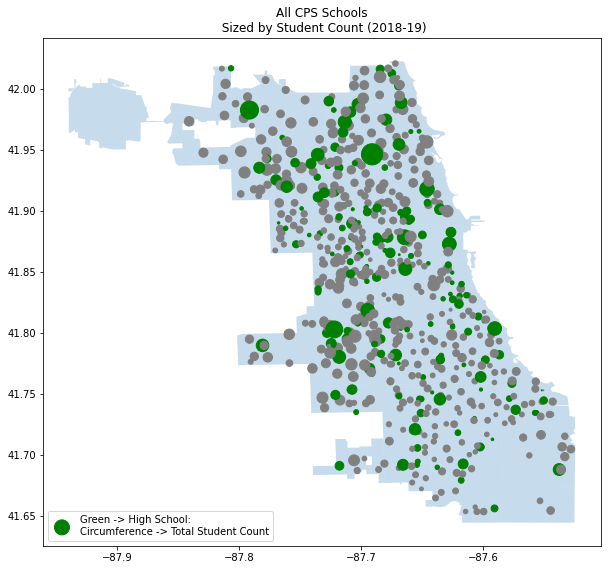

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

chicago_shape.plot(ax=ax, alpha=.25)

geo_df.plot(ax=ax, column=geo_df['Is_High_School'], 
            color = geo_df['school_type_color'],
            markersize=geo_df['Student_Count_Total']/10, 
            legend=True)

ax.set_title('All CPS Schools\n Sized by Student Count (2018-19)')
ax.legend(['Green -> High School:\nCircumference -> Total Student Count']);

<a id='map2'></a>

## Map of All CPS High Schools Colored by Network

This project focuses on graduation rate of CPS high schools. Primary schools do not have graduation rates.  The *isolate_high_schools* function removes all non-high schools from the data set.  The function retains schools which are both primary and high schools.

As printed below, of the 651 total schools in the data set, 176 are high schools.

In [7]:
print(f'There  are {sy_1819.shape[0]} schools in CPS')

# function which removes primary schools from the dataframe
sy_1819_hs = isolate_high_schools(sy_1819)

print(f'There are {sy_1819_hs.shape[0]} high schools in CPS')

There  are 651 schools in CPS
There are 176 high schools in CPS


The cells below use similar code from that used above to create the first map using **Point** objects and **GeoDataFrames**.

In [8]:
# series for all high school longitudes
hs_schools_longs = sy_1819_hs["School_Longitude_sp"]

# series for all high School latitudes
hs_schools_lats = sy_1819_hs["School_Latitude_sp"]

hs_schools_geometry = [Point(long, lat) for long, lat 
                       in zip(hs_schools_longs, hs_schools_lats)]

geo_df_hs= gpd.GeoDataFrame(sy_1819_hs, geometry=hs_schools_geometry)

I also create a GeoDataFrame which contains the top 5 largest schools by `Student_Count_Total`.   This dataframe is used to annotate the map below with the school name.

In [9]:
top_5 = geo_df_hs.sort_values('Student_Count_Total', 
                   ascending=False)[['Short_Name_sp', 'Student_Count_Total', 'geometry', 'Network']].head()
top_5

,Short_Name_sp,Student_Count_Total,geometry,Network
625,LANE TECH HS,4494,POINT (-87.69101 41.94664),Network 14
643,TAFT HS,3294,POINT (-87.79155 41.98296),Network 14
636,CURIE HS,2859,POINT (-87.72204 41.80306),Network 15
202,YOUNG HS,2205,POINT (-87.66423 41.87860),ISP
427,LINCOLN PARK HS,2094,POINT (-87.64601 41.91827),ISP


The map will also be colored by network using the dictionary created below.

In [10]:
network_colors = {'Network 14': 'blue',
                  'Network 15': 'cornflowerblue',
                  'Network 16': 'lightskyblue',
                  'Network 17': 'aqua',
                  'Charter': 'orange',
                  'ISP': 'yellow',
                  'Options': 'red',
                  'AUSL':  'olive', 
                  'Contract': 'palegreen', 
                   np.nan: 'black',}

geo_df_hs['network_colors'] = geo_df_hs['Network'].map(network_colors)


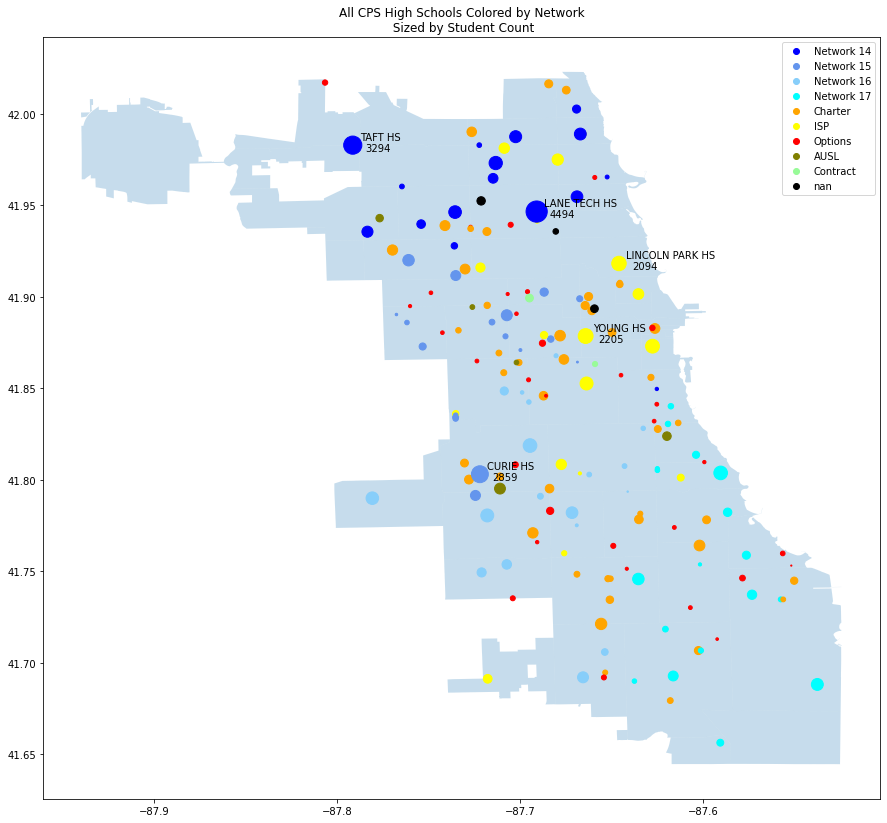

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
chicago_shape.plot(ax=ax, alpha=.25)

geo_df_plot = geo_df_hs.plot(ax=ax, 
            markersize=geo_df_hs['Student_Count_Total']/10, 
            color=geo_df_hs['network_colors'],
            legend=geo_df_hs['network_colors'], )

ax.set_title('All CPS High Schools Colored by Network\n Sized by Student Count')

# Annotate top 5 largest schools with school name and student population
for school in top_5.iterrows():
    pos = (school[1]['geometry'].representative_point().coords[0][0]+.004, 
            school[1]['geometry'].representative_point().coords[0][1]+.003)
    
    pos_count = (school[1]['geometry'].representative_point().coords[0][0]+.007, 
            school[1]['geometry'].representative_point().coords[0][1]-.003)
    
    plt.annotate(school[1]['Short_Name_sp'], xy= pos)
    plt.annotate(school[1]['Student_Count_Total'], xy= pos_count)

# custom legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in network_colors.values()]
ax.legend(markers, network_colors.keys(), numpoints=1)


The main high school networks are numbered 14 through 17, and are colored various shades of blue on the map.  They are composed of neighborhood schools, whose student populations are made of students who live nearby. As can be seen on the maps, the main networks correspond to loosely to latitude bands.

The schools colored **red** above are `Options` schools.  As described on the [CPS website](https://www.cps.edu/schools/networks/network-charter-contract-options/)
> CPS Options schools are designed to be a unique learning model for students who are not engaged in a traditional high school and seek an alternative pathway to graduation that leads to college and career success.

These schools often do not focus on graduation as a priority, and therefore have graduation rates much lower than schools in other networks.  They focus on small populations of students with specific needs. 

When modeling, these `Options` schools, as well as schools designated `Special Education` in the **School Type** column, will be dropped via the `filter_cw_option_special_ed` function below.


The histograms below shows the distribution of graduation rates with and without `Options` and `Special Education` schools.  

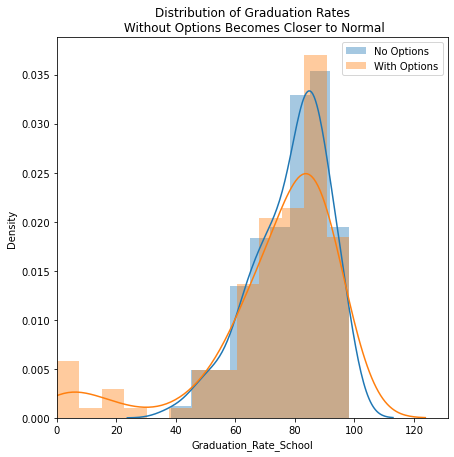

In [12]:
fig, ax = plt.subplots(figsize=(7,7))

sns.distplot(filter_cwoption_special_ed(sy_1819_hs)['Graduation_Rate_School'], 
             ax=ax, hist=True, label='No Options')

sns.distplot(sy_1819_hs['Graduation_Rate_School'], ax=ax, hist=True, label='With Options')
ax.legend()
ax.set_xlim(0)
ax.set_title('Distribution of Graduation Rates\n Without Options Becomes Closer to Normal');

Without options and special education schools, the left tail of the distribution becomes shorter, and the remaining distribution becomes more normal, but still retains a left skew.

In [13]:
print(f"Original distribution skew: {sy_1819_hs['Graduation_Rate_School'].skew()}")
print(f"Skew with neither Options nor Special Ed: {filter_cwoption_special_ed(sy_1819_hs)['Graduation_Rate_School'].skew()}")


Original distribution skew: -1.8122461470300306
Skew with neither Options nor Special Ed: -0.7794224234752357


<a id='map3'></a>

## Map of High Schools with Graduation Rate Outliers Removed 

The `src` folder contains a function `prep_high_school_dataframe` which packages preprocessing, filtering, and feature engineering functions in one place.  

It takes the 4 paths to csv files as arguments: 2 to the most recent year school profile and progress report, and 2 to the school profile and progress report from the year before.  This allows for a function from the `src.feature_engineering` package to construct a column that tracks the change in `Student_Count_Total` from one year to the next. 

There is also a function called `make_percent_demographics` that calculates the rates of different student demographics, such as percent low income and percent special ed.

The prep_high_school_dataframe also has a remove_outlier parameter set to *True* by default.  This argument will remove schools from the dataframe that are "Options" or "Special Education" schools.

In [14]:
path_to_pr_1718 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1718.csv'
path_to_sp_1718 = root + '/data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1718.csv'

sy_1819_hs_prepped = prep_high_school_dataframe(path_to_pr_1819, 
                                        path_to_sp_1819, 
                                        path_to_pr_1718, 
                                        path_to_sp_1718)

0 Student Count
2 schools
139    ENGLEWOOD STEM HS
618       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped
0 Graduation Rate
2 schools
225    PATHWAYS - AVONDALE HS
399     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


The final map in this notebook visualizes non-option high schools.  The size of the markers represents the size of the school, and the color of the market represents the graduation rate. 

In [15]:
# series for each high schools Longitude
hs_schools_longs = sy_1819_hs_prepped["School_Longitude_sp"]

# series for each high schools latitude
hs_schools_lats = sy_1819_hs_prepped["School_Latitude_sp"]

hs_schools_geometry = [Point(long, lat) for long, lat in zip(hs_schools_longs, hs_schools_lats)]

geo_df_hs_prepped= gpd.GeoDataFrame(sy_1819_hs_prepped, geometry=hs_schools_geometry)

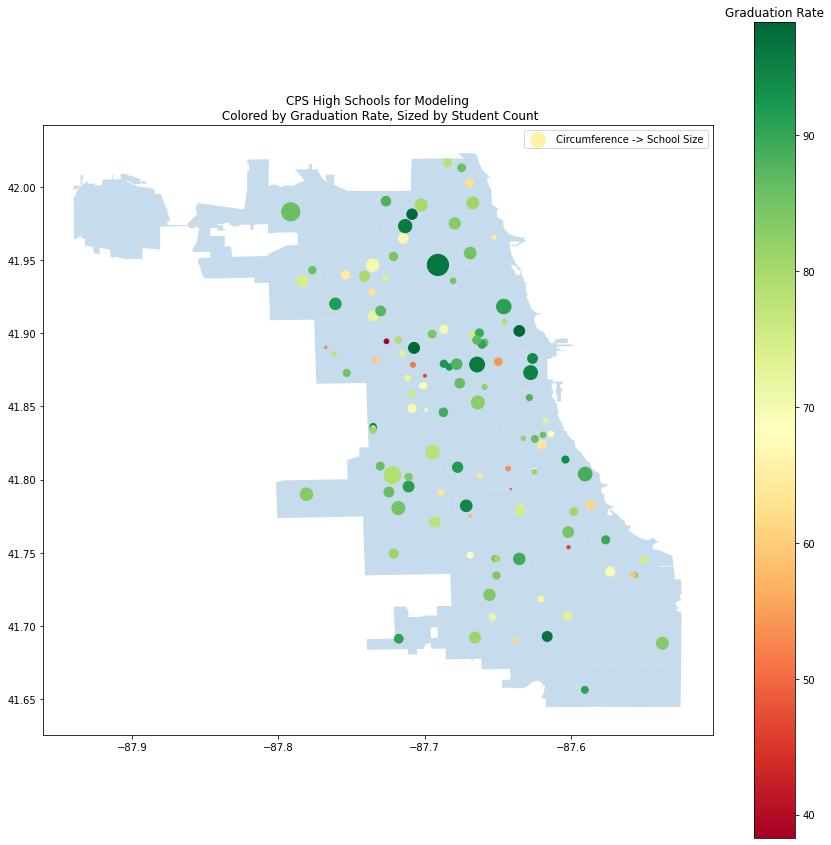

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
chicago_shape.plot(ax=ax, alpha=.25)

geo_df_plot = geo_df_hs_prepped.plot(ax=ax, 
               column=geo_df_hs_prepped['Graduation_Rate_School'],
               markersize=geo_df_hs_prepped['Student_Count_Total']/10,
               cmap='RdYlGn', 
               legend=True)

ax.set_title('CPS High Schools for Modeling\n Colored by Graduation Rate, Sized by Student Count');

# Thanks to this SO: https://stackoverflow.com/questions/50435713/custom-legend-labels-geopandas-plot
colourbar = ax.get_figure().get_axes()[1]
colourbar.set_title('Graduation Rate')

geo_df_plot.legend(['Circumference -> School Size'] )

A few key takeaways from the plot above.

Firstly, there appears to be a geographic trend of low graduation rate schools in the north-west quadrant of the map. Many markers in that area are either red or pale. 

Quantitatively, if we use the map to draw a box around the upper-right quadrant, we see that the graduation means within the box and outside of the box are different.

In [17]:
geo_df_hs_prepped[(geo_df_hs_prepped['School_Longitude_pr'] < -87.68) & 
                  (geo_df_hs_prepped['School_Latitude_pr'] > 41.825)]['Graduation_Rate_School'].mean()

77.32444444444445

In [18]:
geo_df_hs_prepped[~(geo_df_hs_prepped['School_Longitude_pr'] < -87.68) & 
                  (geo_df_hs_prepped['School_Latitude_pr'] > 41.825)]['Graduation_Rate_School'].mean()

83.27931034482758

A one-sided t-test with a p-value of .0255 confirms this.
- alpha: .05
- null hypothesis: High schools in the north-west region of Chicago have graduation rates greater than or equal to high schools outside of that region.
- alternative:  High schools in the north-west region of Chicago have graduation rates less than high schools outside of that region.


In [19]:
ttest_ind(geo_df_hs_prepped[(geo_df_hs_prepped['School_Longitude_pr'] < -87.68) & 
                  (geo_df_hs_prepped['School_Latitude_pr'] > 41.825)]['Graduation_Rate_School'], 
          geo_df_hs_prepped[~(geo_df_hs_prepped['School_Longitude_pr'] < -87.68) & 
                  (geo_df_hs_prepped['School_Latitude_pr'] > 41.825)]['Graduation_Rate_School'], 
          alternative='smaller')

(-1.98459730555965, 0.025500283413538265, 72.0)

The  `northwest_quadrant` function in the feature_engineering file creates a boolean indicating if the school is located in the northwest quadrant. It is implemented in the `prep_high_school_data` frame function as well.

In [20]:
sy_1819_hs_prepped.apply(northwest_quadrant, axis=1)

0      False
1       True
2      False
3      False
4       True
       ...  
127    False
128    False
130    False
132     True
133     True
Length: 123, dtype: bool

There are 45 schools located in the northwest quadrant. 

In [21]:
sy_1819_hs_prepped[sy_1819_hs_prepped['nw_quadrant'] == True].shape[0]

45

There also appears to be a correlation between graduation rate and school size. The red dots, i.e. low graduation rate schools, on the map have either a very small or small-to-medium sized circumference.  The schools with the darkest green, i.e. high graduation rates, look to be either very large or medium-to-large.  

<a id='demcorrs'></a>

# Demographic Count Correlations to Target

The progress report csv's hold student count data.  The cells below investigate these features' correlation to graduation rate. Specifically, they look at the correlation of each feature after it has been converted to percentages of total student count by the `make_percent_demographics` function found in `src.feature_engineering`

In [22]:
# pairplot takes significant time to run.  Uncomment if you are willing to wait
# sns.pairplot(geo_df_hs_prepped[['Graduation_Rate_School'] + STUDENT_POP_PERC_LIST])

<a id='tsc'></a>

### Total Student Count

The visual interpretation of the map indicated a correlation between `Student_Count_Total` and graduation rate. This is backed up by the Pearson correlation, which shows the highest positive correlation to graduation rate. 

In [23]:
geo_df_hs_prepped[['Graduation_Rate_School', 'Student_Count_Total']].corr()

,Graduation_Rate_School,Student_Count_Total
Graduation_Rate_School,1.000000,0.447154
Student_Count_Total,0.447154,1.000000


In [24]:
isolate_important_columns(sy_1819_hs_prepped, 
                          exclude_target=False).corr().iloc[0,:].sort_values(ascending=False)

Graduation_Rate_School                          1.000000
Student_Count_Total                             0.447154
Student_Count_Total                             0.447154
Student_Count_Total_1718                        0.442642
perc_Student_Count_White                        0.313282
perc_Student_Count_Hispanic                     0.295830
perc_Student_Count_Asian                        0.260807
perc_Student_Count_Multi                        0.238127
perc_Student_Count_Ethnicity_Not_Available      0.168099
perc_Student_Count_Asian_Pacific_Islander       0.154735
perc_Student_Count_Native_American              0.090472
perc_Student_Count_Hawaiian_Pacific_Islander    0.009885
student_count_total_change_1_year              -0.033943
perc_Student_Count_English_Learners            -0.141413
Dress_Code                                     -0.275760
perc_Student_Count_Black                       -0.391446
perc_Student_Count_Low_Income                  -0.438595
perc_Student_Count_Low_Income  

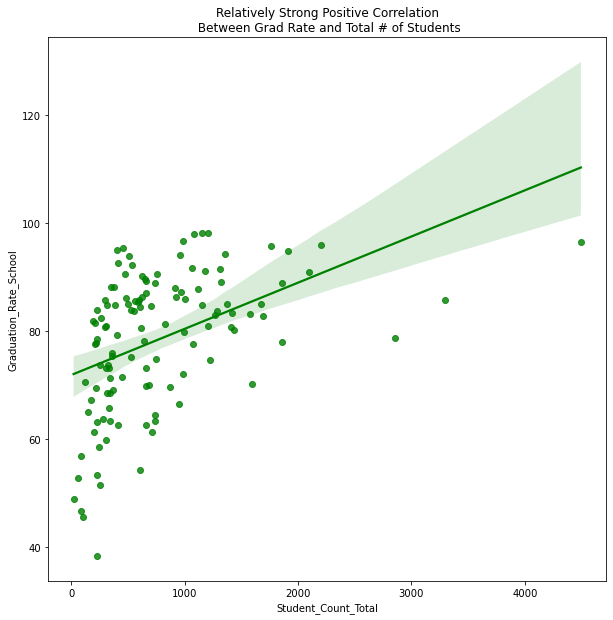

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

sns.regplot(geo_df_hs_prepped['Student_Count_Total'], 
            geo_df_hs_prepped['Graduation_Rate_School'], 
            color='g',
            ax=ax)

ax.set_title('Relatively Strong Positive Correlation\n Between Grad Rate and Total # of Students');

<a id='li'></a>

### Low Income Students

Text(0.5, 0, 'Percent Low Income Students')

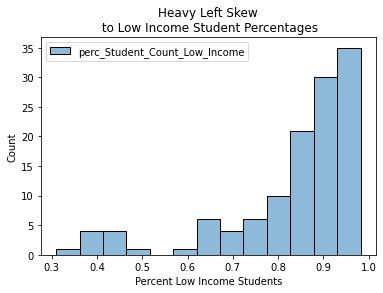

In [26]:
fig, ax = plt.subplots()

sns.histplot(sy_1819_hs_prepped[['perc_Student_Count_Low_Income']], ax=ax);
ax.set_title('Heavy Left Skew\n to Low Income Student Percentages')
ax.set_xlabel('Percent Low Income Students')

In [27]:
sy_1819_hs_prepped[['Graduation_Rate_School', 
                    'perc_Student_Count_Low_Income', 
                    'Student_Count_Low_Income']].corr().iloc[0,:]

Graduation_Rate_School           1.000000
perc_Student_Count_Low_Income   -0.438595
Student_Count_Low_Income         0.376466
Name: Graduation_Rate_School, dtype: float64

The percentage of low income students has a relatively strong negative correlation to Graduation_Rate_School.

<a id='bool'></a>
## Boolean Columns


<a id='charter'></a>
### Charter

Do charter schools have different graduation rates than non-charter schools?

Charter schools are indicated in the Network column of the dataframe.

In [28]:
sy_1819_hs_prepped['Network'].value_counts()

Charter       38
Network 17    18
Network 15    17
Network 16    15
Network 14    13
ISP           12
AUSL           5
Contract       2
Name: Network, dtype: int64

Charter schools will be incorporated into the models via Network One Hot Encoding. I will also try models which only use the charter/non-charter boolean, created by the `is_charter` function in *feature_engineering*.

In [29]:
sy_1819_hs_prepped['is_charter'].value_counts()

False    85
True     38
Name: is_charter, dtype: int64

In [30]:
charter = sy_1819_hs_prepped[sy_1819_hs_prepped['is_charter']==True]
non_charter = sy_1819_hs_prepped[sy_1819_hs_prepped['is_charter']!=True]

Text(0.5, 1.0, 'CPS High School Graduation Rates\n of Charter vs. Non-Charter')

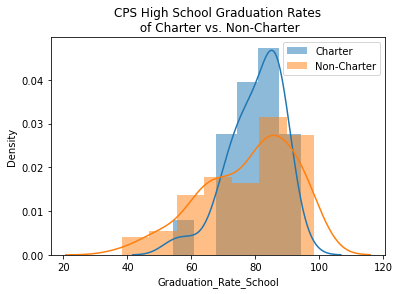

In [31]:
fig, ax = plt.subplots()

sns.distplot(charter['Graduation_Rate_School'], ax=ax, 
             hist_kws = {'alpha': .5}, label="Charter")
sns.distplot(non_charter['Graduation_Rate_School'], ax=ax, 
             hist_kws = {'alpha': .5}, label='Non-Charter' )

ax.legend()
ax.set_title('CPS High School Graduation Rates\n of Charter vs. Non-Charter')

In [32]:
ttest_ind(charter['Graduation_Rate_School'], non_charter['Graduation_Rate_School'], alternative='larger')

(0.9023920348824437, 0.1843207458650981, 121.0)

In [33]:
charter.columns

Index(['School_ID', 'Short_Name_sp', 'Long_Name_sp', 'School_Type',
       'Primary_Category_sp', 'Address_sp', 'City_sp', 'State_sp', 'Zip_sp',
       'Phone_sp',
       ...
       'perc_Student_Count_Asian_Pacific_Islander', 'perc_Student_Count_Multi',
       'perc_Student_Count_Hawaiian_Pacific_Islander',
       'perc_Student_Count_Ethnicity_Not_Available',
       'Student_Count_Total_1718', 'student_count_total_change_1_year',
       'nw_quadrant', 'is_charter', 'is_isp', 'geometry'],
      dtype='object', length=295)

T-test does not indicate a statistically significant difference between charter and non-charter schools.

Similar to the graduation rate distribution, charter schools do not appear visually to have significant differences in low income students than non-charter schools.

Text(0.5, 1.0, 'CPS High School Graduation Rates\n of Charter vs. Non-Charter')

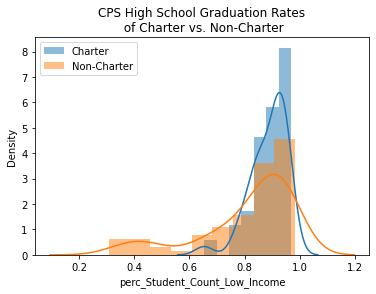

In [34]:
fig, ax = plt.subplots()

sns.distplot(charter['perc_Student_Count_Low_Income'], ax=ax, 
             hist_kws = {'alpha': .5}, label="Charter")
sns.distplot(non_charter['perc_Student_Count_Low_Income'], ax=ax, 
             hist_kws = {'alpha': .5}, label='Non-Charter' )

ax.legend()
ax.set_title('CPS High School Graduation Rates\n of Charter vs. Non-Charter')

<a id='dresscode'></a>
## Dress Code



### Does dress code have an affect on graduation rates?

There are about 2x as many High Schools with Dress Codes than schools without.

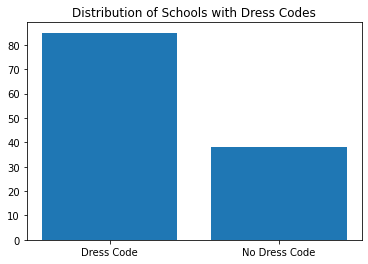

In [35]:
dress_code_counts = sy_1819_hs_prepped['Dress_Code'].value_counts()

fig, ax = plt.subplots()

ax.bar(dress_code_counts.index.astype(str), dress_code_counts.values)
ax.set_title('Distribution of Schools with Dress Codes')
ax.set_xticklabels(['Dress Code', 'No Dress Code']);

In [36]:
## Two-Sample T-test
# Alt Hypothesis: Schools with dress-codes have a significantly a significantly greater graduation rate than those which do not.

dc_grad = sy_1819_hs_prepped[sy_1819_hs_prepped['Dress_Code'] == True]['Graduation_Rate_School']
no_dc_grad = sy_1819_hs_prepped[sy_1819_hs_prepped['Dress_Code'] != True]['Graduation_Rate_School']

ttest_ind(dc_grad, no_dc_grad, alternative='larger')

(-3.155722403169739, 0.9989897161002289, 121.0)

My assumption was incorrect.  It looks as if schools with dress codes have overall lower graduation rates.

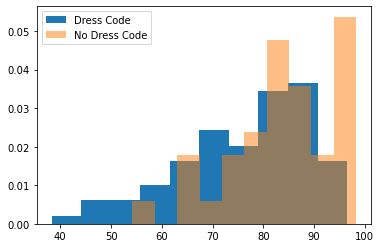

In [37]:
fig, ax = plt.subplots()
ax.hist(dc_grad, density=True, label='Dress Code')
ax.hist(no_dc_grad, density=True, alpha=.5, label='No Dress Code')
ax.legend();

### Does any of the networks have more schools with dress codes than the others?

In [38]:
dress_code_network_count = sy_1819_hs_prepped.groupby("Network").sum()['Dress_Code']

In [39]:
school_in_network_count = sy_1819_hs_prepped.groupby("Network").count()['School_ID']

In [40]:
dress_code_network_count/school_in_network_count

Network
AUSL          0.800000
Charter       0.973684
Contract      0.500000
ISP           0.416667
Network 14    0.461538
Network 15    0.588235
Network 16    0.666667
Network 17    0.666667
dtype: float64

Over 97% of charter schools (all but 1 of the 38), have dress codes.

<a id='categorical'></a>
# Categorical

<a id='networks'></a>
## Networks

Is there a difference in graduation rates across networks?

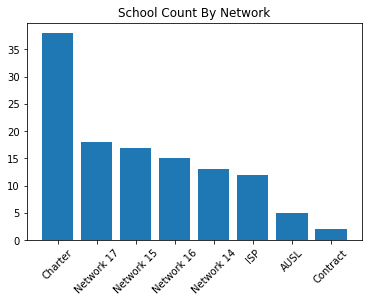

In [41]:
networks = sy_1819_hs_prepped['Network'].value_counts()

fig, ax = plt.subplots()
ax.bar(networks.index, networks.values)
ax.set_xticklabels(networks.index, rotation=45)
ax.set_title("School Count By Network");

In [42]:
sy_1819_hs_prepped[sy_1819_hs_prepped["Network"]=='Contract']

,School_ID,Short_Name_sp,Long_Name_sp,School_Type,Primary_Category_sp,Address_sp,City_sp,State_sp,Zip_sp,Phone_sp,Fax_sp,CPS_School_Profile_sp,Website_sp,Progress_Report_Year,Blue_Ribbon_Award_Year,Excelerate_Award_Gold_Year,Spot_Light_Award_Year,Improvement_Award_Year,Excellence_Award_Year,Student_Growth_Rating,Student_Growth_Description,Growth_Reading_Grades_Tested_Pct_ES,Growth_Reading_Grades_Tested_Label_ES,Growth_Math_Grades_Tested_Pct_ES,Growth_Math_Grades_Tested_Label_ES,Student_Attainment_Rating,Student_Attainment_Description,Attainment_Reading_Pct_ES,Attainment_Reading_Lbl_ES,Attainment_Math_Pct_ES,Attainment_Math_Lbl_ES,Culture_Climate_Rating,Culture_Climate_Description,School_Survey_Student_Response_Rate_Pct,School_Survey_Student_Response_Rate_Avg_Pct,School_Survey_Teacher_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Avg_Pct,School_Survey_Parent_Response_Rate_Pct,School_Survey_Parent_Response_Rate_Avg_Pct,Healthy_School_Certification,Healthy_School_Certification_Description,Creative_School_Certification,Creative_School_Certification_Description,NWEA_Reading_Growth_Grade_3_Pct,NWEA_Reading_Growth_Grade_3_Lbl,NWEA_Reading_Growth_Grade_4_Pct,NWEA_Reading_Growth_Grade_4_Lbl,NWEA_Reading_Growth_Grade_5_Pct,NWEA_Reading_Growth_Grade_5_Lbl,NWEA_Reading_Growth_Grade_6_Pct,NWEA_Reading_Growth_Grade_6_Lbl,NWEA_Reading_Growth_Grade_7_Pct,NWEA_Reading_Growth_Grade_7_Lbl,NWEA_Reading_Growth_Grade_8_Pct,NWEA_Reading_Growth_Grade_8_Lbl,NWEA_Math_Growth_Grade_3_Pct,NWEA_Math_Growth_Grade_3_Lbl,NWEA_Math_Growth_Grade_4_Pct,NWEA_Math_Growth_Grade_4_Lbl,NWEA_Math_Growth_Grade_5_Pct,NWEA_Math_Growth_Grade_5_Lbl,NWEA_Math_Growth_Grade_6_Pct,NWEA_Math_Growth_Grade_6_Lbl,NWEA_Math_Growth_Grade_7_Pct,NWEA_Math_Growth_Grade_7_Lbl,NWEA_Math_Growth_Grade_8_Pct,NWEA_Math_Growth_Grade_8_Lbl,NWEA_Reading_Attainment_Grade_2_Pct,NWEA_Reading_Attainment_Grade_2_Lbl,NWEA_Reading_Attainment_Grade_3_Pct,NWEA_Reading_Attainment_Grade_3_Lbl,NWEA_Reading_Attainment_Grade_4_Pct,NWEA_Reading_Attainment_Grade_4_Lbl,NWEA_Reading_Attainment_Grade_5_Pct,NWEA_Reading_Attainment_Grade_5_Lbl,NWEA_Reading_Attainment_Grade_6_Pct,NWEA_Reading_Attainment_Grade_6_Lbl,NWEA_Reading_Attainment_Grade_7_Pct,NWEA_Reading_Attainment_Grade_7_Lbl,NWEA_Reading_Attainment_Grade_8_Pct,NWEA_Reading_Attainment_Grade_8_Lbl,NWEA_Math_Attainment_Grade_2_Pct,NWEA_Math_Attainment_Grade_2_Lbl,NWEA_Math_Attainment_Grade_3_Pct,NWEA_Math_Attainment_Grade_3_Lbl,NWEA_Math_Attainment_Grade_4_Pct,NWEA_Math_Attainment_Grade_4_Lbl,NWEA_Math_Attainment_Grade_5_Pct,NWEA_Math_Attainment_Grade_5_Lbl,NWEA_Math_Attainment_Grade_6_Pct,NWEA_Math_Attainment_Grade_6_Lbl,NWEA_Math_Attainment_Grade_7_Pct,NWEA_Math_Attainment_Grade_7_Lbl,NWEA_Math_Attainment_Grade_8_Pct,NWEA_Math_Attainment_Grade_8_Lbl,School_Survey_Involved_Families,School_Survey_Supportive_Environment,School_Survey_Ambitious_Instruction,School_Survey_Effective_Leaders,School_Survey_Collaborative_Teachers,School_Survey_Safety,Suspensions_Per_100_Students_Year_1_Pct,Suspensions_Per_100_Students_Year_2_Pct,Suspensions_Per_100_Students_Avg_Pct,Misconducts_To_Suspensions_Year_1_Pct,Misconducts_To_Suspensions_Year_2_Pct,Misconducts_To_Suspensions_Avg_Pct,Average_Length_Suspension_Year_1_Pct,Average_Length_Suspension_Year_2_Pct,Average_Length_Suspension_Avg_Pct,Behavior_Discipline_Year_1,Behavior_Discipline_Year_2,School_Survey_School_Community,School_Survey_Parent_Teacher_Partnership,School_Survey_Quality_Of_Facilities,Student_Attendance_Year_1_Pct,Student_Attendance_Year_2_Pct,Student_Attendance_Avg_Pct,Teacher_Attendance_Year_1_Pct,Teacher_Attendance_Year_2_Pct,Teacher_Attendance_Avg_Pct,One_Year_Dropout_Rate_Year_1_Pct,One_Year_Dropout_Rate_Year_2_Pct,One_Year_Dropout_Rate_Avg_Pct,Other_Metrics_Year_1,Other_Metrics_Year_2,Freshmen_On_Track_School_Pct_Year_2,Freshmen_On_Track_CPS_Pct_Year_2,Freshmen_On_Track_School_Pct_Year_1,Freshmen_On_Track_CPS_Pct_Year_1,Graduation_4_Year_School_Pct_Year_2,Graduation_4_Year_CPS_Pct_Year_2,Graduatio

In [43]:
network_gr = {}
for nw in sy_1819_hs_prepped.groupby('Network'):
    network_gr[nw[0]] = nw[1]['Graduation_Rate_School']

network_gr.values()

dict_values([3     91.2
4     38.3
20    63.4
47    69.5
76    85.6
Name: Graduation_Rate_School, dtype: float64, 11     78.5
14     85.7
24     84.8
25     80.7
26     77.7
29     79.8
31     89.0
34     54.2
35     80.6
37     68.5
39     86.3
52     83.8
54     88.0
59     83.9
60     59.8
68     68.5
77     88.2
87     73.8
90     75.9
92     73.8
95     69.1
98     75.2
101    86.1
102    78.1
108    79.3
109    83.9
110    87.8
111    87.3
112    71.4
113    83.8
114    86.3
115    74.9
117    89.4
118    90.2
119    84.8
120    87.0
121    73.2
122    94.2
Name: Graduation_Rate_School, dtype: float64, 63    82.5
66    84.4
Name: Graduation_Rate_School, dtype: float64, 6      90.7
7      95.5
9      91.8
16     92.2
22     95.1
28     98.2
62     98.0
69     94.9
81     83.1
91     82.8
127    91.0
130    95.9
Name: Graduation_Rate_School, dtype: float64, 15     74.6
30     64.4
38     65.0
40     62.6
44     85.0
53     70.2
75     96.5
80     80.8
82     66.5
85     62.7
86    

In [44]:
f_oneway(*network_gr.values())

F_onewayResult(statistic=3.7215778354198807, pvalue=0.0011710194625368915)

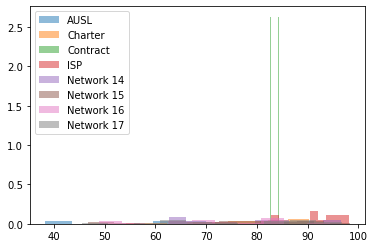

In [45]:
fig, ax = plt.subplots()
for nw, gr_list in network_gr.items():
    ax.hist(gr_list, label=nw, alpha=.5, density=True)
ax.legend()


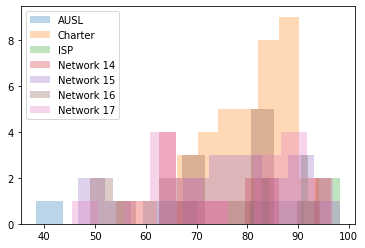

In [46]:
fig, ax = plt.subplots()
for nw, gr_list in network_gr.items():
    if nw != 'Contract':
        ax.hist(gr_list, label=nw, alpha=.3, density=False)
ax.legend()


### Do ISP Schools Have Significantly Higher Graduation Rates

In [47]:
sy_1819_hs_prepped[sy_1819_hs_prepped['Network']=="ISP"].shape[0]

12

(array([ 1.,  3.,  4.,  5., 11., 17., 15., 30., 17.,  8.]),
 array([38.3, 44.3, 50.3, 56.3, 62.3, 68.3, 74.3, 80.3, 86.3, 92.3, 98.3]),
 <BarContainer object of 10 artists>)

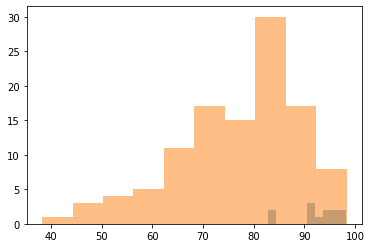

In [48]:
isp = sy_1819_hs_prepped[sy_1819_hs_prepped['Network']=="ISP"]['Graduation_Rate_School']
not_isp = sy_1819_hs_prepped[sy_1819_hs_prepped['Network']!="ISP"]['Graduation_Rate_School']

fig, ax = plt.subplots()

ax.hist(isp, label=nw, alpha=.5, density=False)
ax.hist(not_isp, label=nw, alpha=.5, density=False)

(array([0.0015015 , 0.0045045 , 0.00600601, 0.00750751, 0.01651652,
        0.02552553, 0.02252252, 0.04504505, 0.02552553, 0.01201201]),
 array([38.3, 44.3, 50.3, 56.3, 62.3, 68.3, 74.3, 80.3, 86.3, 92.3, 98.3]),
 <BarContainer object of 10 artists>)

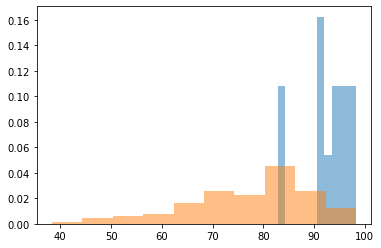

In [49]:
fig, ax = plt.subplots()

ax.hist(isp, label=nw, alpha=.5, density=True)
ax.hist(not_isp, label=nw, alpha=.5, density=True)

In [50]:
ttest_ind(isp, not_isp)

(4.22918654731832, 4.582534385861721e-05, 121.0)

ISP's have a significantly higher mean graduation rate than non-isp schools.

The `is_isp` function in the feature_engineering.py creates an boolean column that indicates if a school is an ISP.

In [51]:
sy_1819_hs_prepped['Network'].apply(is_isp).sum()

12